In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import gaussian_kde 
from scipy.spatial import distance

### In this notebook, we compare our data distributions before and after scaling

We are curious whether or not the climate invariant scaling (in this case, scaling `I` by lifetime `I_max` over the storm) improves our generalizability. For now we just look at generalizability across basins but we may extend this to seasons. 

Plotting the KDE for each basin for a give forecast time on a log scale. Labels change whether or not we are plotting `I` or `I_scaled`

In [3]:
def make_log_KDE_plt(ax,X,x_plt,is_legend=True):
    sns.set_style("darkgrid")
    if (x_plt == 'VMAX') | (x_plt == 'VMAX norm'):
        sns.kdeplot(data=X,x=x_plt,hue='BASIN',linewidth=7,palette='twilight',ax=ax,legend=is_legend)
        ax.set_xlabel('Intensity (kt)',fontsize=30)
        ax.set_title('TC Intensity',fontsize=42)
    else:
        sns.kdeplot(data=X,x=x_plt,hue='BASIN',linewidth=7,palette='twilight',ax=ax,legend=is_legend)
        ax.set_xlabel('Scaled Intensity',fontsize=30)
        ax.set_title('Scaled TC Intensity',fontsize=42)
    ax.set_ylabel('log(Density)',fontsize=30)
    ax.tick_params(axis='both',labelsize=20)
    ax.set_yscale('log') 
    if is_legend:
        sns.move_legend(ax, "upper right", fontsize=17,title_fontsize=20)
    
    return ax

Plotting a histogram for each basin for a give forecast time on a log scale. Labels change whether or not we are plotting `I` or `I_scaled`. A histogram versus a KDE--the histogram will allow us to see if any data points are super-intense (`I_scaled > 1`), which can be harder to see on a KDE. 

In [4]:
def make_log_hist_plt(ax,X,x_plt,is_legend=True):
    sns.set_style("darkgrid")
    if (x_plt == 'VMAX') | (x_plt == 'VMAX norm'):
        sns.histplot(data=X,x=x_plt,hue='BASIN',bins=21,palette='twilight',multiple='stack',element='step',
                     ax=ax,legend=is_legend,fill=False,linewidth=4)
        ax.set_xlabel('Intensity (kt)',fontsize=30)
        ax.set_title('TC Intensity',fontsize=42)
    else:
        sns.histplot(data=X,x=x_plt,hue='BASIN',bins=21,palette='twilight',multiple='stack',element='step',
                     ax=ax,legend=is_legend,fill=False,linewidth=4)
        ax.set_xlabel('Scaled Intensity',fontsize=30)
        ax.set_title('Scaled TC Intensity',fontsize=42)
    ax.set_ylabel('log(Density)',fontsize=30)
    ax.tick_params(axis='both',labelsize=20)
    ax.set_yscale('log') 
    if is_legend:
        sns.move_legend(ax, "upper right", fontsize=17,title_fontsize=20)
    
    return ax

#### Calc_pdf_dist

We want a metric to estimate how similar data distributions are to each other. Specifically, what we will ultimately test is the difference between two basins before and after scaling `I` by `I_max`. Here, we'll use the Jensen-Shannon distance b/c it's more sensitive to the tails of the distribution. 

Jensen-Shannon distance:

$$JS(p,q) = \sqrt{ \frac{1}{2} \left[ KL(p,q) + KL(q,p)\right]},$$

where $KL$ is the Kullback-Leibler divergence, definfed as:

$$KL(p,q) = \int_0^1 dx \times p(x) \ln \left[ \frac{p(x)}{q(x)}\right]$$

This is how we'll evaluate our PDF differences

##### to-do: add Hellinger dist (it's not built-in in Python)

In [5]:
def calc_pdf_dist(p,q,p_bins,q_bins):
    p_norm = (p - np.min(p))/(np.max(p) - np.min(p))
    q_norm = (q - np.min(q))/(np.max(q) - np.min(q))
    # Calculate KDEs
    kde_p = gaussian_kde(p)
    kde_pn = gaussian_kde(p_norm)
    #
    kde_q = gaussian_kde(q)
    kde_qn = gaussian_kde(q_norm)
    #
    p_bins = np.linspace(0,170,41)
    q_bins = np.linspace(0,1.3,41)
    #
    norm_bins = np.linspace(0,1,41)
    # Get distance
    pdf_p = kde_p.pdf(p_bins)
    pdf_pn = kde_pn.pdf(norm_bins)
    pdf_q = kde_q.pdf(q_bins)
    pdf_qn = kde_qn.pdf(norm_bins)
    #
    dist = distance.jensenshannon(pdf_p,pdf_q)
    dist_norm = distance.jensenshannon(pdf_pn,pdf_qn)
    return dist,dist_norm

### 1. Load preprocessed data

In [13]:
interp_str = 'INTERP'
fname_save = 'DATA/SHIPS_processed_ALL_BASINS_I_scaled_landmask_{interp_str}.csv'.format(interp_str=interp_str)
SHIPS_load = pd.read_csv(fname_save)

##### Look at data really quickly just to see the spread

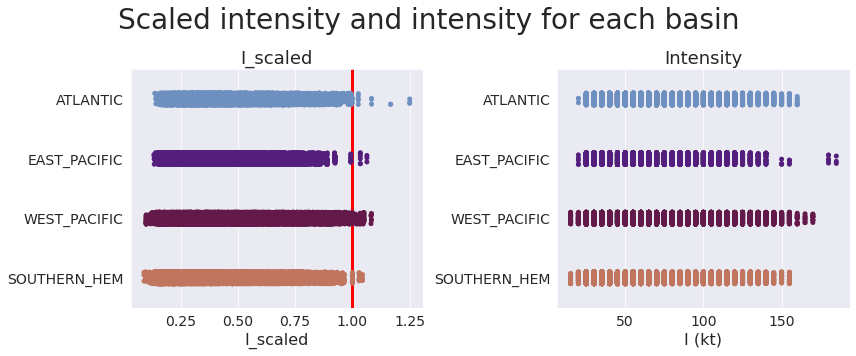

In [30]:
sns.set_style("darkgrid")
fig10,(ax10a,ax10b) = plt.subplots(1,2,figsize=(12,5))
sns.stripplot(data=SHIPS_load.reset_index(),x='I_scaled',y='BASIN',ax=ax10a,palette='twilight')
ax10a.axvline(1,color='r',linewidth=3)
ax10a.tick_params(axis='both',labelsize=14)
ax10a.set_ylabel(None)
ax10a.set_xlabel('I_scaled',fontsize=16)
ax10a.set_title('I_scaled',fontsize=18)
#
sns.stripplot(data=SHIPS_load.reset_index(),x='VMAX',y='BASIN',ax=ax10b,palette='twilight')
ax10b.set_title('Intensity',fontsize=18)
ax10b.tick_params(axis='both',labelsize=14)
ax10b.set_ylabel(None)
ax10b.set_xlabel('I (kt)',fontsize=16)
#
fig10.suptitle('Scaled intensity and intensity for each basin',fontsize=28)
fig10.tight_layout()

#### Double check that extreme outliers in EPac are Patricia
If we turn on `remove_patricia` flag we can drop Patricia

In [31]:
xsel = SHIPS_load.set_index(['BASIN','ATCF ID','CASE','TIME'])
# 
remove_patricia = False
if remove_patricia:
    xsel = xsel.reset_index()[xsel.reset_index()['ATCF ID']!='EP202015']
    xsel = xsel.set_index(['BASIN','ATCF ID','CASE','TIME'])

### 2.Plot distributions for each forecast time

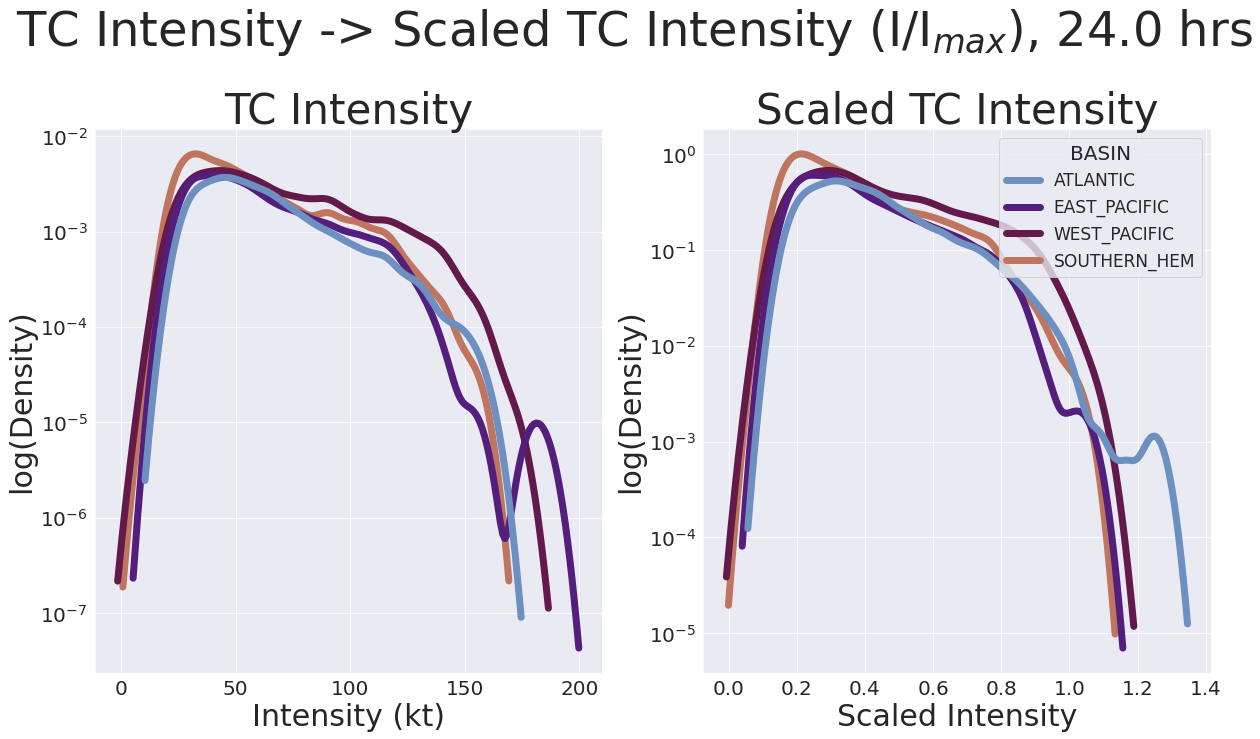

In [36]:
fore_time_ALL = xsel.reset_index()['TIME'].unique().tolist()
for time_sel in fore_time_ALL:
    fig1,(ax1a,ax1b) = plt.subplots(1,2,figsize=(20,10))
    X = xsel.xs(time_sel,level=3).reset_index()
    make_log_KDE_plt(ax1a,X,'VMAX',is_legend=False)
    #
    make_log_KDE_plt(ax1b,X,'I_scaled')
    ax1b.set_xlabel('Scaled Intensity',fontsize=30)

    fig1.suptitle('TC Intensity -> Scaled TC Intensity (I/I$_{{max}}$), {hr} hrs'.format(hr=time_sel),fontsize=48,y=1.05)
    if remove_patricia:
        fname_save = 'Figures/data_PDFs/TCI_vs_scaled_TCI_{hr}hr_forecast_NO_PATRICIA.png'.format(hr=time_sel)
    else:
        fname_save = 'Figures/data_PDFs/TCI_vs_scaled_TCI_{hr}hr_forecast.png'.format(hr=time_sel)
    fig1.savefig(fname_save,format='png',dpi=300,bbox_inches='tight')
    # display only one plot
    if time_sel != 24:
        plt.close()

### 2. Normalize `VMAX` and `I_scaled`
This way we ensure that `I_scaled` can't be greater than 1. We normalized in the following way:

$$ X_{norm} = \frac{X - min(X)}{max(X) - min(X)} $$

After we normalize, we make the same set of distribution plots but with our normalized data. 

In [34]:
xx = xsel.reset_index().groupby(['BASIN','TIME'])[['VMAX','I_scaled']].transform(lambda x: (x - np.min(x))/(np.max(x) - np.min(x)))
xsel['VMAX norm'] = xx['VMAX'].values
xsel['IS norm'] = xx['I_scaled'].values

In [35]:
for time_sel in fore_time_ALL:
    fig2,(ax2a,ax2b) = plt.subplots(1,2,figsize=(20,10))
    X = xsel.xs(time_sel,level=3).reset_index()
    make_log_KDE_plt(ax2a,X,'VMAX norm',is_legend=False)
    #
    make_log_KDE_plt(ax2b,X,'IS norm')
    fig2.suptitle('TC Intensity -> Scaled TC Intensity (I/I$_{{max}}$), {hr} hrs [Normalized]'.format(hr=time_sel),fontsize=44,y=1.05)
    #
    if remove_patricia:
        fname_save2 = 'Figures/data_PDFs/NORMALIZED_TCI_vs_scaled_TCI_{hr}hr_forecast_NO_PATRICIA.png'.format(hr=time_sel)
    else:
        fname_save2 = 'Figures/data_PDFs/NORMALIZED_TCI_vs_scaled_TCI_{hr}hr_forecast.png'.format(hr=time_sel)
    fig2.savefig(fname_save2,format='png',dpi=300,bbox_inches='tight')
    # Display only 1 plot
    if time_sel != 24:
        plt.close()


### 3. Same as above, but with actual histograms
Histograms instead of KDE plots to better understand where our data begins and ends and to ensure normalization works.  

Intensity (not scaled)

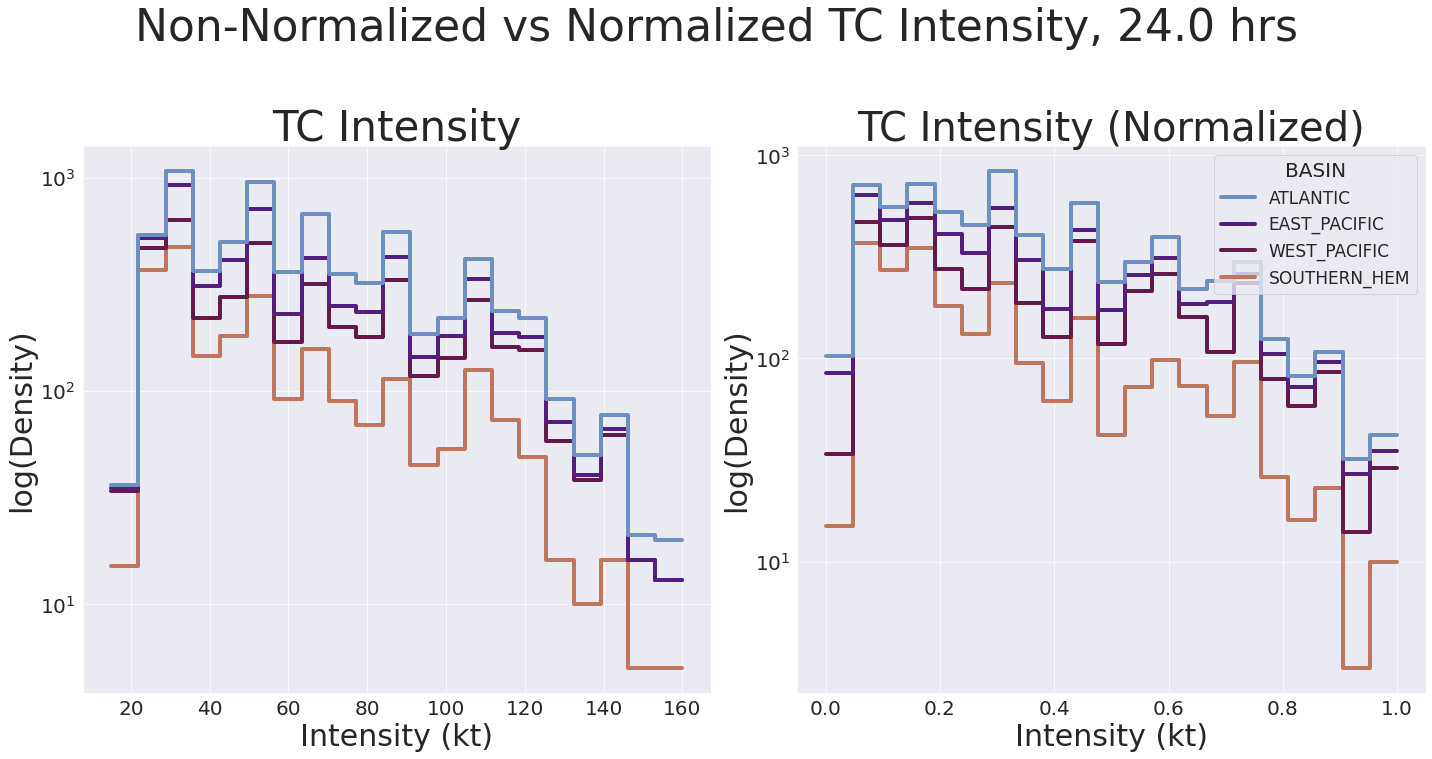

In [37]:
for time_sel in fore_time_ALL:
    fig3,(ax3a,ax3b) = plt.subplots(1,2,figsize=(20,10))
    make_log_hist_plt(ax3a,X,'VMAX',is_legend=False)
    #
    make_log_hist_plt(ax3b,X,'VMAX norm',is_legend=True)
    ax3b.set_title('TC Intensity (Normalized)',fontsize=40)
    fig3.suptitle('Non-Normalized vs Normalized TC Intensity, {hr} hrs'.format(hr=time_sel),fontsize=44,y=1.05)
    fig3.tight_layout()
    #
    if remove_patricia:
        fname_save3 = 'Figures/data_PDFs/hist_non_vs_NORMALIZED_TCI_{hr}hr_forecast_NO_PATRICIA.png'.format(hr=time_sel)    
    else:
        fname_save3 = 'Figures/data_PDFs/hist_non_vs_NORMALIZED_TCI_{hr}hr_forecast.png'.format(hr=time_sel)
    fig3.savefig(fname_save3,format='png',dpi=300,bbox_inches='tight')
    if time_sel != 24:
        plt.close()


Scaled intensity

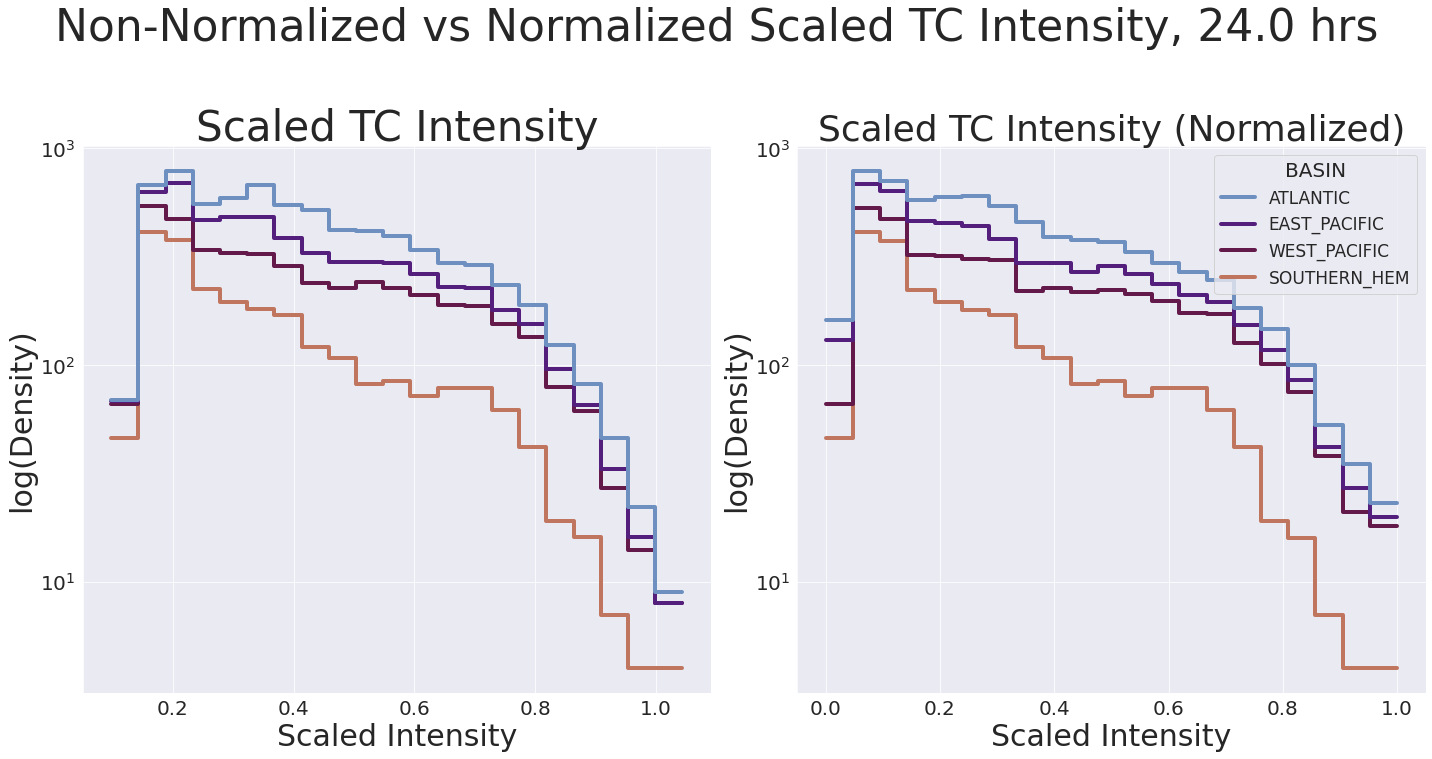

In [38]:
for time_sel in fore_time_ALL:
    fig4,(ax4a,ax4b) = plt.subplots(1,2,figsize=(20,10))
    make_log_hist_plt(ax4a,X,'I_scaled',is_legend=False)
    #
    make_log_hist_plt(ax4b,X,'IS norm',is_legend=True)
    ax4b.set_title('Scaled TC Intensity (Normalized)',fontsize=36)
    fig4.suptitle('Non-Normalized vs Normalized Scaled TC Intensity, {hr} hrs'.format(hr=time_sel),fontsize=44,y=1.05)
    fig4.tight_layout()
    #
    if remove_patricia:
        fname_save4 = 'Figures/data_PDFs/hist_non_vs_NORMALIZED_scaled_TCI_{hr}hr_forecast_NO_PATRICIA.png'.format(hr=time_sel)
    else:
        fname_save4 = 'Figures/data_PDFs/hist_non_vs_NORMALIZED_scaled_TCI_{hr}hr_forecast.png'.format(hr=time_sel)
    fig4.savefig(fname_save4,format='png',dpi=300,bbox_inches='tight')
    if time_sel != 24:
        plt.close()


### 4. Actually get PDF distances
Now we'll calculate the distances between our distributions for each basin. We'll loop through each pair of basins (which is redundant but oh well) and calculate the difference between the `I` and `I_scaled` distributions. We'll do this for normalized and not-normalized data.  

In [14]:
# Initialize dataframes 
pdf_dist_ALL_VMAX = pd.DataFrame()
pdf_dist_ALL_IS = pd.DataFrame()
basins_ALL = xsel.reset_index()['BASIN'].unique().tolist()
fore_hr = xsel.reset_index()['TIME'].unique().tolist()
# Loop through each pair of basins. Probably a smarter way to do this but oh well
for i_basin1 in basins_ALL:
    for i_basin2 in basins_ALL:
        # Preallocated dataframes again
        pdf_dist_vm = pd.DataFrame(columns={'JS (norm)','JS (not norm)','BASIN 1','BASIN 2','Forecast Hr'},
                                      index=fore_hr)
        pdf_dist_IS = pd.DataFrame(columns={'JS (norm)','JS (not norm)','BASIN 1','BASIN 2','Forecast Hr'},
                                      index=fore_hr)
        # Now get dist for each forecast time
        for fore_time in fore_hr:
            # Calculate distances for I_scaled
            px = xsel.xs(fore_time,level=3).xs(i_basin1).reset_index()['I_scaled']
            qx = xsel.xs(fore_time,level=3).xs(i_basin2).reset_index()['I_scaled']
            #
            bins_IS = np.linspace(0,1.3,41)
            d,dn = calc_pdf_dist(px,qx,bins_IS,bins_IS)
            pdf_dist_IS['BASIN 1'].loc[fore_time] = i_basin1
            pdf_dist_IS['BASIN 2'].loc[fore_time] = i_basin2
            pdf_dist_IS['Forecast Hr'].loc[fore_time] = fore_time
            pdf_dist_IS['JS (norm)'].loc[fore_time] = dn
            pdf_dist_IS['JS (not norm)'].loc[fore_time] = d
            # Calculate distances for I
            pxv = xsel.xs(fore_time,level=3).xs(i_basin1).reset_index()['VMAX']
            qxv = xsel.xs(fore_time,level=3).xs(i_basin2).reset_index()['VMAX']
            bins_VM = np.linspace(0,170,41)
            dv,dnv = calc_pdf_dist(pxv,qxv,bins_VM,bins_VM)
            #
            pdf_dist_vm['BASIN 1'].loc[fore_time] = i_basin1
            pdf_dist_vm['BASIN 2'].loc[fore_time] = i_basin2
            pdf_dist_vm['Forecast Hr'].loc[fore_time] = fore_time
            pdf_dist_vm['JS (norm)'].loc[fore_time] = dnv
            pdf_dist_vm['JS (not norm)'].loc[fore_time] = dv
            ##
        # After we've gone through all forecast times for a given pair of basins, append and restart
        pdf_dist_ALL_VMAX = pdf_dist_ALL_VMAX.append(pdf_dist_vm,ignore_index=True)
        pdf_dist_ALL_IS = pdf_dist_ALL_IS.append(pdf_dist_IS,ignore_index=True)


In [15]:
pdf_dist_ALL_VMAX = pdf_dist_ALL_VMAX.set_index(['BASIN 1','BASIN 2','Forecast Hr'])
pdf_dist_ALL_IS = pdf_dist_ALL_IS.set_index(['BASIN 1','BASIN 2','Forecast Hr'])

### 5. Compare Intensity and Scaled Intensity

Ultimately we want to know if our scaling (`I_scaled`) makes our intensity predictions more generalizable across basins. A first step is seeing if the distributions for each basins are closer together for `I_scaled` versus `I`. We'll calculate:

$$ diff = D(I_s) - D(I)$$

So if `diff < 0`, our intensity scaling is bringing the different basins closer together. If `diff > 0`, our intensity scaling is making basins farther apart. 

In [16]:
pdf_dist_ALL_VMAX['Diff (IS - VMAX)'] = pdf_dist_ALL_IS['JS (norm)'] - pdf_dist_ALL_VMAX['JS (norm)']
# Change to float for pivot table
pdf_dist_ALL_VMAX['Diff (IS - VMAX)'] = pdf_dist_ALL_VMAX['Diff (IS - VMAX)'].astype(float)

Make a pivot table for plotting the heatmap

In [18]:
piv = pd.pivot_table(data=pdf_dist_ALL_VMAX,
                     values='Diff (IS - VMAX)',
                     index = ['BASIN 1','Forecast Hr'], columns = 'BASIN 2')

### 6. Plot `diff`

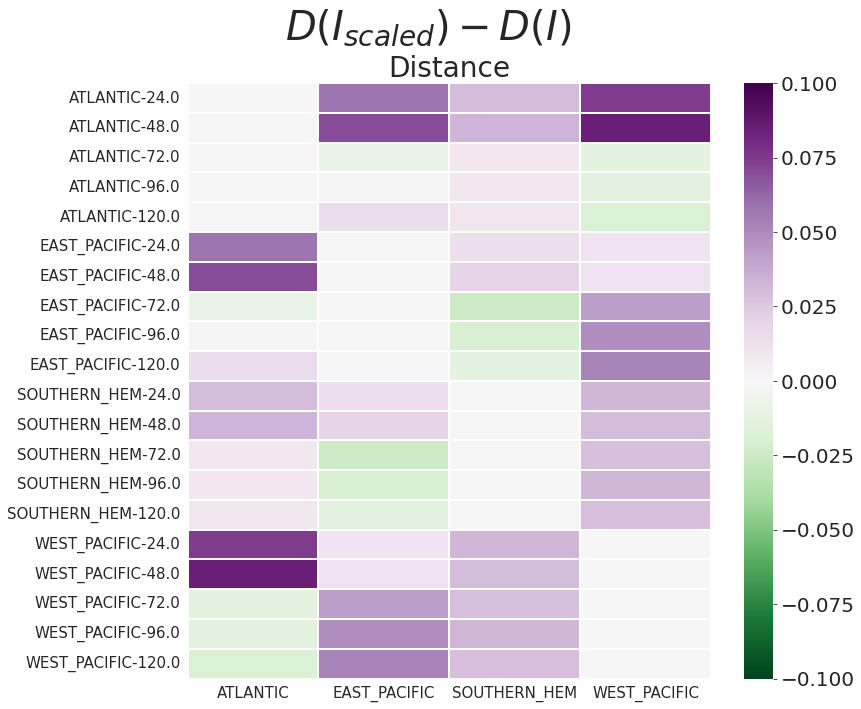

In [19]:
fig5,ax5 = plt.subplots(1,1,figsize=(12,10))
plt5 = sns.heatmap(piv,cmap='PRGn_r',vmax=0.1,vmin=-0.1,ax=ax5,linewidth=2)
ax5.tick_params('both',labelsize=15)
ax5.set_xlabel(None)
ax5.set_ylabel(None)
#ax5.set_xticklabels(pdf_dist_ALL_VMAX.reset_index()['BASIN 2'].unique().tolist(),rotation=20,fontsize=20)
cbarc = plt5.collections[0].colorbar
cbarc.ax.tick_params(labelsize=20)
ax5.set_title('Distance',fontsize=28)
fig5.suptitle('$D(I_{scaled}) - D(I)$',fontsize=40)
fig5.tight_layout()
#
if remove_patricia:
    fname_save5 = 'Figures/data_PDFs/DIs_minus_DI_normalized_ALL_NO_PATRICIA.png'
else:
    fname_save5 = 'Figures/data_PDFs/DIs_minus_DI_normalized_ALL.png'
fig5.savefig(fname_save5,format='png',dpi=300,bbox_inches='tight')
